# Boundary conditions

In [2]:
import numpy as np
import scipy as sp
import os
import sys
from scipy import optimize
from scipy import integrate
from scipy import interpolate
from matplotlib import pyplot as plt

## Import model

In [3]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

In [4]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)

In [5]:
m.findAllTransitions()

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[{'low_vev': array([202.04374412, 482.78409962]),
  'high_vev': array([9.51180104e-06, 1.78261369e+02]),
  'Tnuc': 61.79608446346483,
  'low_phase': 0,
  'high_phase': 1,
  'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.00000000e+00, 1.04060051e-05, 1.88910615e-03, 3.76780630e-03,
         5.64650644e-03, 7.52520659e-03, 9.40390674e-03, 1.12826069e-02,
         1.31613070e-02, 1.50400072e-02, 1.69187073e-02, 1.87974075e-02,
         2.06761076e-02, 2.25548078e-02, 2.44335079e-02, 2.63122081e-02,
         2.81909082e-02, 3.00696083e-02, 3.19483085e-02, 3.38270086e-02,
         3.57057088e-02, 3.75844089e-02, 3.94631091e-02, 4.13418092e-02,
         4.32205094e-02, 4.50992095e-02, 4.69779097e-02, 4.88566098e-02,
         5.07353100e-02, 5.26140101e-02, 5.44927102e-02, 5.63714104e-02,
         5.82501105e-02, 6.01288107e-02, 6.20075108e-02, 6.38862110e-02,
         6.57649111e-02, 6.76436113e-02, 6.95223114e-02, 7.14010116e-02,
         7.32797117e-02, 7.51584118e-02, 7.70

In [37]:
m.TnTrans[0].keys()

dict_keys(['low_vev', 'high_vev', 'Tnuc', 'low_phase', 'high_phase', 'instanton', 'action', 'trantype', 'crit_trans', 'rho+', 'rho-', 'p+', 'p-', 'ep+', 'ep-'])

## Thermodynamic quantities

In [6]:
def derivative(f, x, eps=1e-5, order=1):
    """Calculate the derivative of a function.
    Using Ridders algorithm.
    Calculate up to order x**4.
    Only compute 1st or 2nd order derivative."""
    assert (
        order == 1 or order == 2
    ), "Calculate derivative up to an order, must be 1 or 2."
    δx = x * eps
    if order == 1:
        return (f(x - 2 * δx) - 8 * f(x - δx) + 8 * f(x + δx) - f(x + 2 * δx)) / (
            12 * δx
        )
    if order == 2:
        return (f(x - 2 * δx) - f(x - δx) - f(x + δx) + f(x + 2 * δx)) / (3 * δx**2)

In [7]:
def cs_sq(V,T, vev):
    """Sound speed square."""
    def VT(T):
        return V(vev,T)
    return derivative(VT, T, order=1)/(T*derivative(VT, T, order=2))

In [8]:
cs_sq(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev'])

0.33379900900581405

In [11]:
cs_sq(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev'])

0.29347226243359037

In [8]:
def epsilon(V,T,vev):
    """Epsilon."""
    def VT(T):
        return V(vev,T)
    return - 0.25*T*derivative(VT,T) + VT(T)

In [9]:
def a(V,T, vev):
    """The parameter a, means the effective dofs."""
    def VT(T):
        return V(vev,T)
    return - 0.75 * derivative(VT,T)/T**3

In [10]:
def alpha_p(V, Tp, Tm, high_vev, low_vev):
    return (epsilon(V,Tp,high_vev) - epsilon(V,Tm, low_vev))/(a(V,Tp, high_vev) * Tp**4)

In [11]:
def r_func(V,Tp,Tm, high_vev, low_vev):
    return a(V,Tp, high_vev)*Tp**4/(a(V,Tm, low_vev)*Tm**4)

In [48]:
epsilon(m.Vtot,m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev'])

-13250675.64721587

In [49]:
epsilon(m.Vtot,m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev'])

-1001338.1690678224

In [53]:
alpha_p(m.Vtot,61.95, 61.0, m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev'])

0.09631938161494871

## Solve detonation

In [12]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(m.Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(m.Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

In [14]:
match(0.7,0.5,61.8, 61.0, m.TnTrans[0]['high_vev'],m.TnTrans[0]['low_vev'])

[0.37488767629163944, 0.676399039862079]

In [15]:
def guess_det(vp, Tp, ap, am, εp, εm):
    αp = (εp-εm)/(ap*Tp**4)
    r=1/(1+3*αp)
    Tm = (ap*Tp**4/(am*r))**0.25
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    vm = min(vpvm/vp, 0.67)
    return [vm,Tm]

In [22]:
def vJ(alphap):
    v = (alphap*(2+3*alphap))**0.5 + 1
    v = v/((1+alphap)*3**0.5)
    return v

In [23]:
alpha_p(m.Vtot, m.TnTrans[0]['Tnuc'], 81.51196995,m.TnTrans[0]['high_vev'],m.TnTrans[0]['low_vev'] )

0.050858596835864606

In [24]:
vJ(0.050858596835864606)

0.7311924971667051

In [21]:
vw=0.6
guess = guess_det(vw, m.TnTrans[0]['Tnuc'],a(m.Vtot,  m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), a(m.Vtot,m.TnTrans[0]['Tnuc']*1.1,m.TnTrans[0]['low_vev']),epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev']))
print(guess)
optimize.fsolve(lambda x:match(vw, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)

[0.67, 69.4428590655021]


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.40596061, 81.51196995])

In [18]:
optimize.fsolve(lambda x:match(0.7, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.50929031, 78.62803497])

## Solve deflagration

In [13]:
guess_sol = optimize.fsolve(lambda x:match(x[0],0.5,x[1], 60, m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),[0.3, m.TnTrans[0]['Tnuc']], xtol=1e-10)
guess_sol

array([ 0.31077114, 66.30557572])

In [1]:
def dYda(tau, y, *args):
    """Y: (v, xi, T)"""
    v = y[0]
    xi = y[1]
    T = y[2]
    V=args[0]
    vev=args[1]
    dvdtau = 2 * v * cs_sq(V, T, vev) * (1-v**2) * (1- xi * v)
    dxidtau = xi *((xi-v)**2 - cs_sq(V,T,vev) * (1-xi*v)**2)
    dvdxi = 2*v/xi * (1-v**2)
    dvdxi = dvdxi/(1-v*xi)/(μ(xi, v)**2/cs_sq(V,T,vev) - 1)
    dTdxi = T * μ(xi, v) * dvdxi / (1-v**2)
    dTdtau = dTdxi * dxidtau
    return np.array([dvdtau, dxidtau, dTdtau])

def μ(x, v):
    return (x-v)/(1-x*v)


def dTdx(x, y, *args):
    T = y[0]
    v_prof=args[0]
    dT = T/(1-v_prof(x)**2)
    dT = dT * μ(x, v_prof(x)) * v_prof.derivative()(x)
    return np.array([dT])

In [14]:
vsol=integrate.solve_ivp(dYda, (10,1), np.array([μ(0.5, guess_sol[0]), 0.5, guess_sol[1]]),t_eval=np.linspace(10,1,1000),method='DOP853', args=(m.Vtot, m.TnTrans[0]['high_vev']))

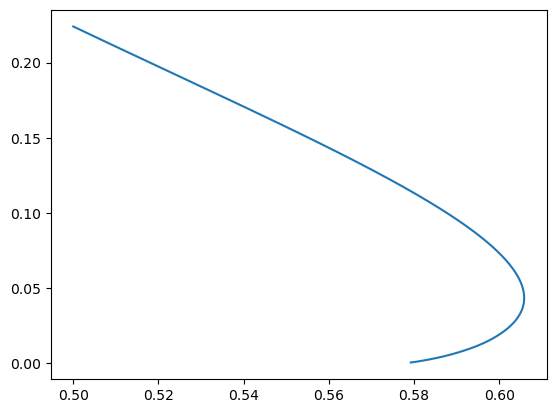

In [15]:
plt.plot(vsol.y[1],vsol.y[0])

In [16]:
xi_max = vsol.y[1].max()
xi_max_index = vsol.y[1].argmax()
v_prof = interpolate.UnivariateSpline(vsol.y[1][0:xi_max_index+1], vsol.y[0][0:xi_max_index+1], s=0)

In [19]:
xi_max

0.605831301288266

In [17]:
vsol.t[xi_max_index]

7.342342342342342

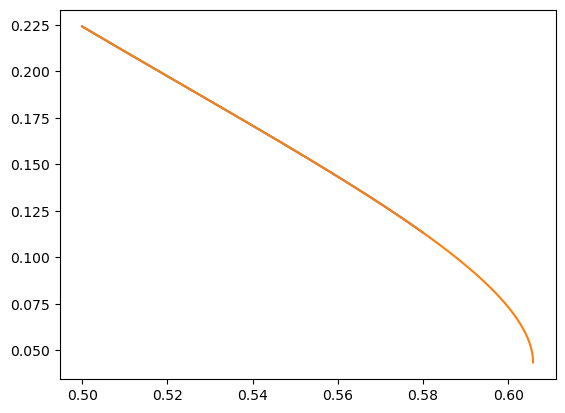

In [18]:
xplot = np.linspace(0.5, 0.58, 100)
vplot = [v_prof(x) for x in xplot]
plt.plot(xplot, vplot)
plt.plot(vsol.y[1][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])

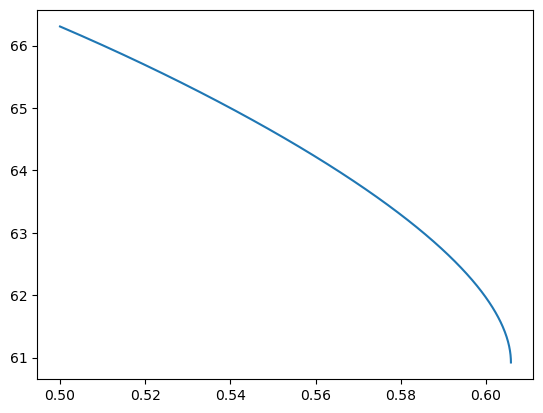

In [20]:
plt.plot(vsol.y[1][0:xi_max_index+1], vsol.y[2][0:xi_max_index+1])

In [35]:
T_prof = interpolate.interp1d(vsol.y[1][0:xi_max_index+1],vsol.y[2][0:xi_max_index+1])

In [36]:
xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(m.Vtot, T_prof(x), m.TnTrans[0]['high_vev']), 0.5, xi_max*0.999)
xsh

0.6013272621769765

In [46]:
T_prof(xsh)

array(62.75519737)

In [23]:
def find_Tsh(Tm):
    guess_sol = optimize.fsolve(lambda x:match(x[0], 0.5, x[1], Tm,m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),[0.1, m.TnTrans[0]['Tnuc']])
    vsol=integrate.solve_ivp(dYda, (10,0.01), np.array([μ(0.5, guess_sol[0]), 0.5, guess_sol[1]]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(m.Vtot, m.TnTrans[0]['high_vev']))
    xi_max = vsol.y[1].max()
    xi_max_index = vsol.y[1].argmax()
    v_prof = interpolate.interp1d(vsol.y[1][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
    T_prof = interpolate.interp1d(vsol.y[1][0:xi_max_index+1],vsol.y[2][0:xi_max_index+1])
    xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(m.Vtot, T_prof(x), m.TnTrans[0]['high_vev']), 0.5, xi_max*0.999)
    return T_prof(xsh)

In [24]:
find_Tsh(55)

array(58.32940407)

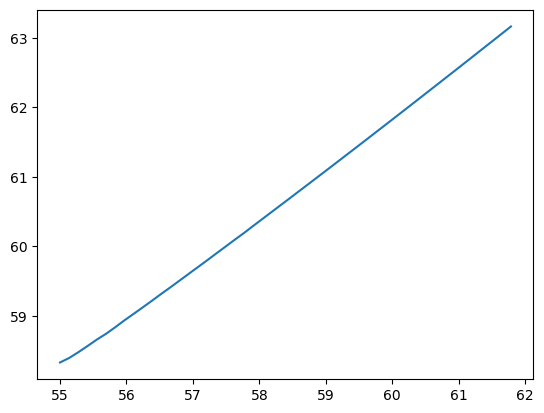

In [37]:
Tmlist = np.linspace(55, m.TnTrans[0]['Tnuc']-0.01, 50)
Tshlist = [find_Tsh(Tm) for Tm in Tmlist]
plt.plot(Tmlist, Tshlist)

In [38]:
tfunc = interpolate.interp1d(Tmlist, Tshlist)
optimize.brentq(lambda T: tfunc(T) - m.TnTrans[0]['Tnuc'], 55, m.TnTrans[0]['Tnuc']-0.01)

59.96316001304336

In [40]:
Tmax = m.TnTrans[0]['Tnuc']
Tmin = 55
for i in range(200):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal)
    if Tsh < m.TnTrans[0]['Tnuc']:
        Tmin = Tcal
    else:
        Tmax = Tcal

In [41]:
Tcal

59.96295743883299

In [39]:
find_Tsh(59.96316001304336)

array(61.79624534)

In [42]:
find_Tsh(Tcal)

array(61.79632345)

In [28]:
m.TnTrans[0]['Tnuc']

61.79608446346483